In [1]:

!pip install gymnasium stable-baselines3[extra] -q

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import torch
from stable_baselines3 import SAC
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.8 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
class RoboticFingerEnv(gym.Env):
    def __init__(self):
        super().__init__()
        # State: [angle, angular_velocity]
        self.observation_space = spaces.Box(
            low=np.array([-np.pi, -5.0]),
            high=np.array([np.pi, 5.0]),
            dtype=np.float32
        )
        # Action: torque in range [-2, 2]
        self.action_space = spaces.Box(
            low=np.array([-2.0]),
            high=np.array([2.0]),
            dtype=np.float32
        )
        self.dt = 0.02  # time step
        self.goal_angle = np.pi / 4  # desired position
        self.reset()

    def step(self, action):
        torque = np.clip(action[0], -2.0, 2.0)
        # Simple dynamics: θ_ddot = torque - damping * θ_dot
        damping = 0.1
        self.angular_velocity += (torque - damping * self.angular_velocity) * self.dt
        self.angle += self.angular_velocity * self.dt

        # Reward: negative absolute position error
        error = self.goal_angle - self.angle
        reward = -abs(error)

        # Done condition
        done = abs(error) < 0.02  # if goal reached
        truncated = False

        return np.array([self.angle, self.angular_velocity], dtype=np.float32), reward, done, truncated, {}

    def reset(self, seed=None, options=None):
        self.angle = np.random.uniform(-np.pi/2, np.pi/2)
        self.angular_velocity = 0.0
        return np.array([self.angle, self.angular_velocity], dtype=np.float32), {}

    def render(self):
        print(f"Angle: {self.angle:.2f}, Velocity: {self.angular_velocity:.2f}")

In [4]:
env = RoboticFingerEnv()
model = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=3e-4,
    buffer_size=100000,
    batch_size=64,
    tau=0.005,
    gamma=0.99,
    train_freq=1,
    gradient_steps=1,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

model.learn(total_timesteps=100000, progress_bar=True)
model.save("sac_finger")

print("Training Complete")

/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/usr/local/lib/python3.12/dist-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: 
datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects 
to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)

Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Streaming output truncated to the last 5000 lines.
|    n_updates       | 38610    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 59.3     |
|    ep_rew_mean     | -43      |
| time/              |          |
|    episodes        | 524      |
|    fps             | 83       |
|    time_elapsed    | 463      |
|    total_timesteps | 38959    |
| train/             |          |
|    actor_loss      | 20.8     |
|    critic_loss     | 0.0103   |
|    ent_coef        | 0.0314   |
|    ent_coef_loss   | 0.00879  |
|    learning_rate   | 0.0003   |
|    n_updates       | 38858    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 58.9     |
|    ep_rew_mean     | -42.4    |
| time/              |          |
|    episodes        | 528      |
|    fps             | 84       |
|    time_elapsed    | 466      |
|    total_timesteps | 39181   

Training Complete


In [5]:
obs, _ = env.reset()
angles = []
goals = []
rewards = []

for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, trunc, _ = env.step(action)
    angles.append(obs[0])
    goals.append(env.goal_angle)
    rewards.append(reward)
    if done:
        break

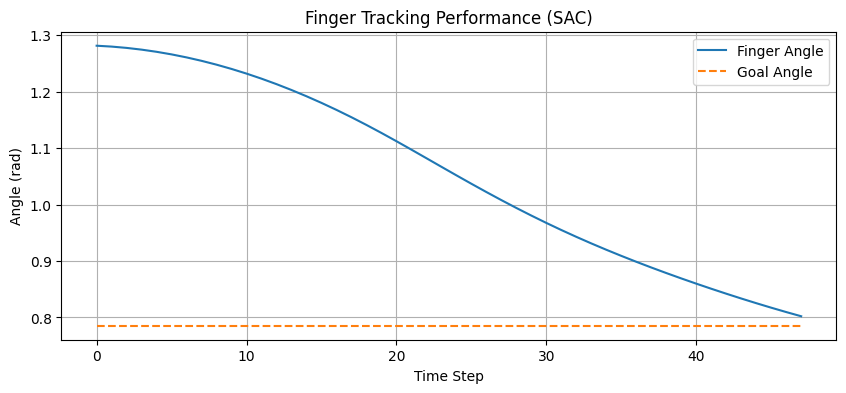

In [6]:
plt.figure(figsize=(10,4))
plt.plot(angles, label="Finger Angle")
plt.plot(goals, "--", label="Goal Angle")
plt.xlabel("Time Step")
plt.ylabel("Angle (rad)")
plt.title("Finger Tracking Performance (SAC)")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import imageio
import matplotlib.pyplot as plt
import numpy as np

In [10]:
import matplotlib
matplotlib.use("Agg")  # ensure Agg backend
def render_finger(angle, goal_angle):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect("equal")
    ax.set_title("Robotic Finger")

    # Base and goal visualization
    ax.plot([0, np.cos(goal_angle)], [0, np.sin(goal_angle)], "--g", label="Goal")
    ax.plot([0, np.cos(angle)], [0, np.sin(angle)], "-ob", label="Finger")

    ax.legend()
    ax.grid(True)

    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(height, width, 4)
    plt.close(fig)
    return img[..., :3]

In [11]:
frames = []
obs, _ = env.reset()

for _ in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, trunc, _ = env.step(action)
    img = render_finger(obs[0], env.goal_angle)
    frames.append(img)
    if done:
        break

imageio.mimsave("finger_sac.gif", frames, fps=20)
print("GIF saved as 'finger_sac.gif'")

/usr/local/lib/python3.12/dist-packages/imageio/plugins/pillow.py:410: DeprecationWarning: The keyword `fps` is no longer supported. Use `duration`(in ms) instead, e.g. `fps=50` == `duration=20` (1000 * 1/50).
  warnings.warn(


GIF saved as 'finger_sac.gif'


In [12]:
from IPython.display import Image

In [13]:
def simulate_robotic_finger(model, env, save_path="robotic_finger_sim.gif", steps=300):
    obs, _ = env.reset()
    frames = []

    link_length = 0.8  # arm length
    base = np.array([0, 0])  # pivot point

    for t in range(steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, trunc, _ = env.step(action)

        angle = obs[0]
        goal = env.goal_angle

        # Plot setup
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_aspect('equal')
        ax.set_title(f"Robotic Finger (t={t})")

        # Draw finger
        end_effector = base + link_length * np.array([np.cos(angle), np.sin(angle)])
        ax.plot([base[0], end_effector[0]], [base[1], end_effector[1]], color='blue', lw=5, label='Finger')

        # Draw goal position
        goal_point = base + link_length * np.array([np.cos(goal), np.sin(goal)])
        ax.scatter(goal_point[0], goal_point[1], color='green', s=100, label='Goal')

        # Optional: draw trajectory
        ax.plot([end_effector[0]], [end_effector[1]], 'or', markersize=6)

        ax.legend(loc="upper right")
        ax.grid(True)

        # Convert to image frame
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        frames.append(img[..., :3])

        if done:
            break

    # Save animation
    imageio.mimsave(save_path, frames, fps=25)
    print(f"Simulation GIF saved as '{save_path}'")
    return save_path


Simulation GIF saved as 'robotic_finger_sim.gif'


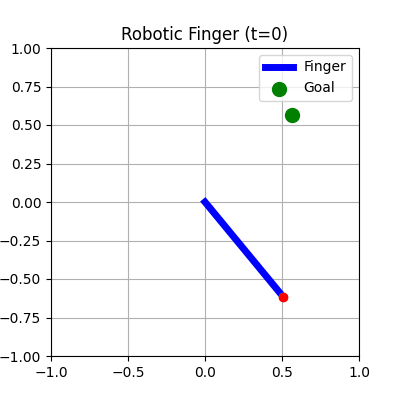

In [14]:
gif_path = simulate_robotic_finger(model, env)
Image(filename=gif_path)

In [15]:
pip install panda-gym gymnasium pybullet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pybullet: filename=pybullet-3.2.7-cp312-cp312-linux_x86_64.whl size=99873466 sha256=056692fa7bf771099b5fecef6cb1ba36f1e0465d9ae6a3099483a4bb9ee48ef6
  Stored in directory: /root/.cache/pip/wheels/72/95/1d/b336e5ee612ae9a019bfff4dc0bedd100ee6f0570db205fdf8
Successfully built pybullet


Output()

/usr/local/lib/python3.12/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

Using cuda device
🚀 Training started...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -12.6    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 412      |
|    time_elapsed    | 0        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 46.2     |
|    ep_rew_mean     | -11.1    |
|    success_rate    | 0.125    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 427      |
|    time_elapsed    | 0        |
|    total_timesteps | 370      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 47.5     |
|    ep_rew_mean     | -10.9    |
|    success_rate    | 0.0833   |
| time/              |          |
|    epi

✅ Training complete!
🎞️ GIF saved as panda_reach_sim.gif


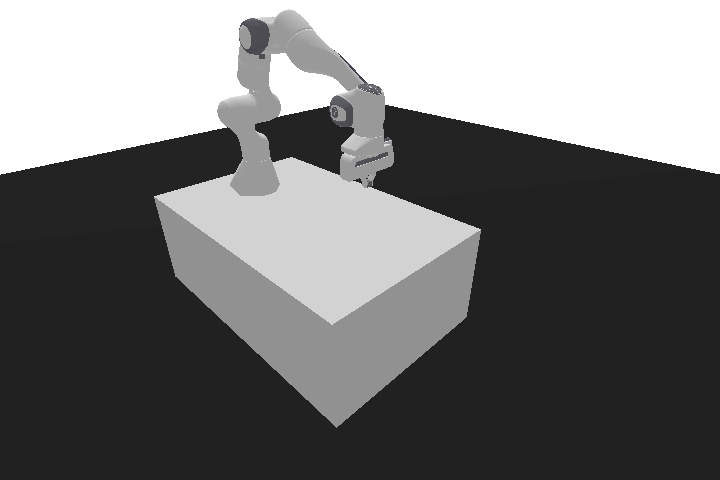

In [16]:
# ============================================================
# ✅ PANDA REACH SIMULATION (SAC TRAINING + GIF)
# ============================================================

!pip install panda-gym gymnasium stable-baselines3[extra] imageio[ffmpeg] -q

import gymnasium as gym
import panda_gym
from stable_baselines3 import SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
import numpy as np
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image

# ============================================================
# STEP 1: CREATE ENVIRONMENTS
# ============================================================

def make_env():
    env = gym.make("PandaReachDense-v3", render_mode="rgb_array")
    env = Monitor(env)
    return env

env = DummyVecEnv([make_env])

# ============================================================
# STEP 2: TRAIN SAC MODEL
# ============================================================

model = SAC(
    policy="MultiInputPolicy",
    env=env,
    learning_rate=3e-4,
    buffer_size=100000,
    batch_size=256,
    tau=0.02,
    gamma=0.98,
    verbose=1,
    train_freq=1,
    gradient_steps=1,
    learning_starts=1000,
    device="cuda"
)

print("🚀 Training started...")
model.learn(total_timesteps=10000, progress_bar=True)
model.save("sac_panda_reach")
print("✅ Training complete!")

# ============================================================
# STEP 3: RUN SIMULATION AND RECORD FRAMES
# ============================================================

env = gym.make("PandaReachDense-v3", render_mode="rgb_array")
obs, info = env.reset()
frames = []

for step in range(200):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, trunc, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    if done or trunc:
        obs, info = env.reset()

env.close()

# ============================================================
# STEP 4: SAVE AS GIF
# ============================================================

gif_path = "panda_reach_sim.gif"
imageio.mimsave(gif_path, frames, fps=30)
print(f"🎞️ GIF saved as {gif_path}")

Image(filename=gif_path)
